In [1]:
## Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Bayesian fitting
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand

# Fitting
from scipy.optimize import minimize
from iminuit import Minuit

In [2]:
# Import my own functions developed for AppStat2020
import sys

# Load own library
sys.path.append('../AppStat_Functions')
import General_functions as AppStars

In [3]:
SaveFig = True

# Import Data

In [4]:
data = np.loadtxt('Data/Exam_2022_Prob1.txt')
data

array([[22.173312,  0.164244, 11.      ,  1.144988,  2.412222],
       [20.695507, -0.552985,  9.      ,  1.190298,  0.979081],
       [21.77794 , -0.219681, 12.      ,  1.10739 ,  1.500416],
       ...,
       [20.491821,  0.810158, 14.      ,  1.237308,  1.915955],
       [25.731616,  0.316386,  6.      ,  1.097451,  2.068088],
       [24.766123,  0.178929, 11.      ,  1.132097,  0.84715 ]])

# Visualize all Columns

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


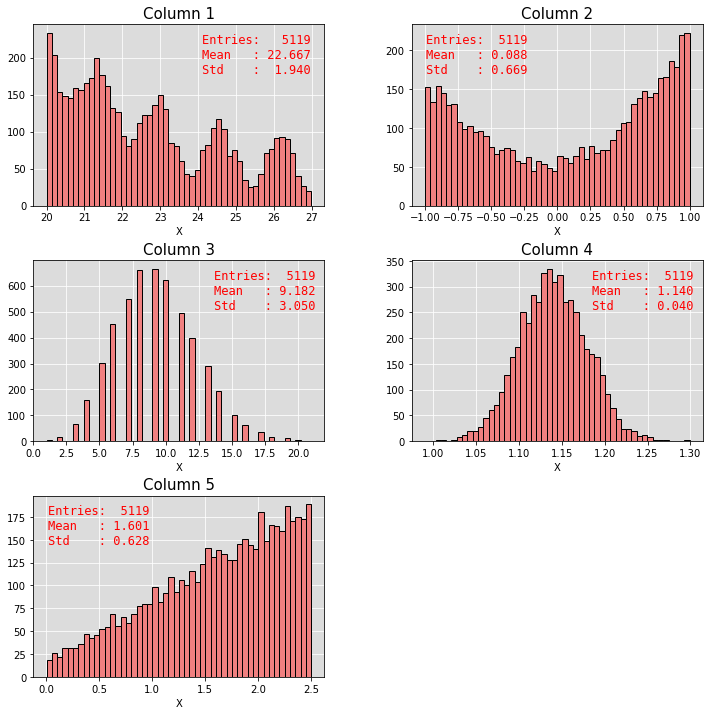

In [5]:
# Make fig
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), gridspec_kw={'wspace':0.3, 'hspace':0.3})
fig.delaxes(ax[2,1])
ax = ax.flatten()

# Define coordinates to plot
x_coords = [0.58, 0.05, 0.62, 0.62, 0.05]

# Loop over variables
for i in range(5):
    
    ax[i].hist(data[:,i], bins=50, color='lightcoral', ec='k', zorder=3)
    ax[i].set_title(f'Column {i+1}', fontsize=15)
    
    ax[i].set_facecolor('gainsboro')
    ax[i].grid(color='white')
    
    ax[i].set_xlabel('X')
    
    d = {r'Entries:': len(data[:,i]),
         r'Mean   :': np.mean(data[:,i]),
         r'Std    :': np.std(data[:,i], ddof=1)
         }
    text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
    AppStars.add_text_to_ax(x_coords[i], 0.95, text, ax[i], fontsize=12, color='red')
    
if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_1.pdf')
    
plt.show()

## First Column
We need to find the function that the data is sampled from. A list of functions is provided in the problem text.

First of all, we see the data is periodical. Furthermore it is decreasing in probability for larger values. There is also no dampening of the sine function, so it is probably this function:
$$\sin(ax)+ce^{bx}+1$$

We used nested sampling with UltraNest, something with local minima and more robust. We use the example:
https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

In [6]:
# The function is truncated
xlim = (20,27)

# Array to plot in
x_arr = np.linspace(xlim[0], xlim[1], 1000)

### Fitting with Nested Sampling

In [7]:
# Define the function we want to fit
def fit_func_1(x, a, b, c):
    return np.sin(a*x) + c * np.exp(b*x) + 1

# Normalise the function so it resembles a PDF
def norm_func_1(x, a, b, c):
    
    # Get area nummerically
    A = np.trapz(fit_func_1(x_arr, a, b, c), x_arr)
    
    # Normalise
    return 1/A * fit_func_1(x, a, b, c) 

# Def the param names
param_names = ['a', 'b', 'c']

# Define the bounds on the parameters from the slide
bounds = [ (-10,10), (-10,10), (4000,8000) ]

# Define the prior, we assume uniform within bounds
def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    # Copy parameters
    params = cube.copy()
    
    # Transform 'a'
    lo = bounds[0][0]
    hi = bounds[0][1]
    params[0] = cube[0] * (hi - lo) + lo
    
    # Transform 'b'
    lo = bounds[1][0]
    hi = bounds[1][1]
    params[1] = cube[1] * (hi - lo) + lo
    
    # Transform 'c'
    lo = bounds[2][0]
    hi = bounds[2][1]
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

# Define likelihood
def log_likelihood(params):
    
    # Compute for each x point, where it should lie in y
    y_model = norm_func_1(data[:,0],*params)
    
    # Compute likelihood
    # THIS IS DONE DIFFERENTLY IN THE EXAMPLE SOMETHING ABOUT ERRORS
    llh = np.sum(np.log(y_model)) 
    return llh

In [8]:
# Initialise sampler
sampler = ultranest.ReactiveNestedSampler(param_names, log_likelihood, prior_transform)

# Seed
np.random.seed(1)

# Run it
result = sampler.run(min_num_live_points=400)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


[ultranest] Explored until L=-9e+03  302.01 [-9302.0426..-9302.0426]*| it/evals=8440/58077 eff=14.6332% N=400 
[ultranest] Likelihood function evaluations: 58083
[ultranest]   logZ = -9319 +- 0.1486
[ultranest] Effective samples strategy satisfied (ESS = 1717.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -9318.534 +- 0.303
  single instance: logZ = -9318.534 +- 0.195
  bootstrapped   : logZ = -9318.523 +- 0.303
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    a                   : 3.8910│ ▁▁ ▁▁▁▁▁▂▂▂▄▃▅▅▆▆▇▇▇▇▇▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁ │3.9075    3.8992 +- 0.0020
    b                   : -0.3814│ ▁▁▁▁▂▂▃▅▇▇▇▇▇▆▆▆▆▅▄▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁ │-0.3278    -0.3596 +- 0.0085
    c         

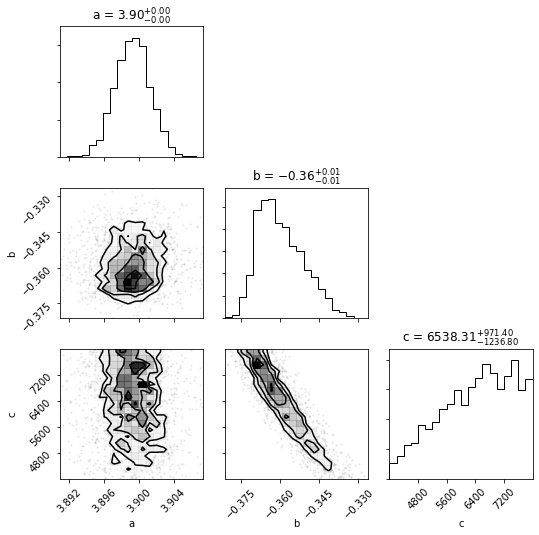

In [9]:
# Display results in cornerplot
cornerplot(result)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_2.pdf')

In [10]:
# Get results as pandas frame
df_fit1 = pd.DataFrame(data=result['samples'], columns=result['paramnames'])
df_fit1.describe()

# Extract the fit parameters
a_val_err = (np.mean(df_fit1['a']), np.std(df_fit1['a']))
b_val_err = (np.mean(df_fit1['b']), np.std(df_fit1['b']))
c_val_err = (np.mean(df_fit1['c']), np.std(df_fit1['c']))
print(f'a is: {a_val_err[0]:.4f} +/- {a_val_err[1]:.4f}')
print(f'b is: {b_val_err[0]:.4f} +/- {b_val_err[1]:.4f}')
print(f'c is: {c_val_err[0]:.4f} +/- {c_val_err[1]:.4f}')

a is: 3.8992 +/- 0.0020
b is: -0.3596 +/- 0.0085
c is: 6426.0623 +/- 1002.4680


### Chi2 Test
This depends on the binning. We don't want fewer than 5 entries in each bin. We choose 50 bins.
We use a critical p-value of 0.05, i.e. if the p-value is below 0.05 the hypothesis that the entries are sampled from the function.

In [11]:
# Extract values from histogram and outline data
N_bins = 50
counts, bin_edges = np.histogram(data[:,0], bins=N_bins);
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
binwidth = bin_edges[1] - bin_edges[0]

# Poisson errors on the count in each bin
s_counts = np.sqrt(counts)
    
# We remove any bins, which don't have any counts in them:
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = norm_func_1(x, a_val_err[0], b_val_err[0], c_val_err[0]) 
y_exp = f_plot * len(data[:,0]) * binwidth 

# Degrees of freedom
N_ddof = len(x) - 3 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2_col_1 = np.sum( (y-y_exp)**2 / y_exp )
prob1 = stats.chi2.sf(chi2_col_1, df=N_ddof) 
print(f'The Chi2 is: {chi2_col_1:.4f} with a p-value of: {prob1:.4f}')

The Chi2 is: 35.3981 with a p-value of: 0.8929


### Plotting

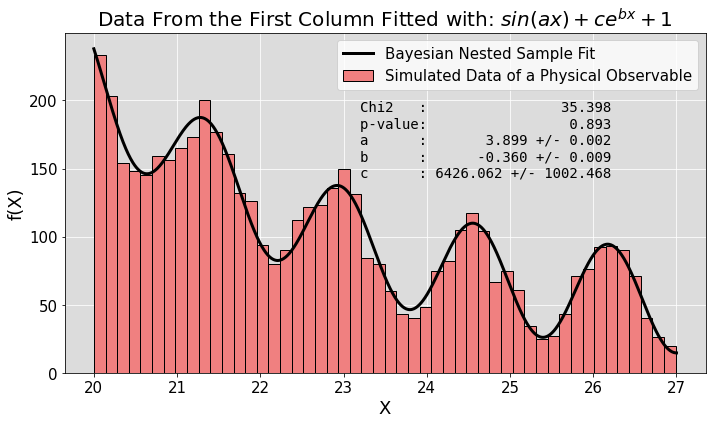

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot the data
ax.hist(data[:,0], N_bins, color='lightcoral', ec='k', zorder=2, 
        label='Simulated Data of a Physical Observable')

# Plot the fit
y_arr = norm_func_1(x_arr, a_val_err[0], b_val_err[0], c_val_err[0]) * len(data[:,0]) * binwidth 
ax.plot(x_arr, y_arr, color='k', linewidth=3, zorder=3, label='Bayesian Nested Sample Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2   :': chi2_col_1,
     r'p-value:': prob1,
     r'a      :': f'{a_val_err[0]:.3f} +/- {a_val_err[1]:.3f}',
     r'b      :': f'{b_val_err[0]:.3f} +/- {b_val_err[1]:.3f}',
     r'c      :': f'{c_val_err[0]:.3f} +/- {c_val_err[1]:.3f}',
    }

text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
AppStars.add_text_to_ax(0.46, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data From the First Column Fitted with: $sin(ax)+ce^{bx}+1$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('f(X)', fontsize=18)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_3.pdf')
    
plt.show()

## Second Column
Look like a parabola, we will try:
$$ 1+ax+bx^2 $$
There is only on minimum, so we will go with a simple unbinned max likelihood minuit fit.

In [13]:
# The function is truncated
xlim2 = (-1,1)

# Array plot in
x_arr2 = np.linspace(xlim2[0], xlim2[1], 1000)

### Fitting with Minuit

In [14]:
# Define the function we want to fit with
def fit_func_2(x, a, b):
    return 1 + a*x + b*x**2

# Normalise the function so it resembles a PDF, return function of x
def norm_func_2(x, a, b):
    
    # Get area nummerically
    A = np.trapz(fit_func_2(x_arr2, a, b), x_arr2)
    
    # Normalise
    return 1/A * fit_func_2(x, a, b)

def target_func(a, b):
    
    # Make pdf in the truncated interval
    pdf = norm_func_2(data[:,1], a, b)

    # Calculate the log likelihood 
    llh = np.sum(np.log(pdf))
    
    # Return negative llh, when minimizing = max likelihood
    return -llh

In [15]:
# Ensures the errors are right, for neg log likelihood UP=0.5
# See p. 39 here https://root.cern.ch/download/minuit.pdf
target = target_func
target.errordef = Minuit.LIKELIHOOD

# Define parameters initial guess - in the middle of bound for now
params = {'a': 0, 'b': 0}

# Initialize minimizer
minimizer = Minuit(target, **params)

# Enforce bounds
minimizer.limits['a'] = (-10,10)
minimizer.limits['b'] = (-10,10)

# Actually minimize
minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3085                       │              Nfcn = 55               │
│ EDM = 3.37e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.47    │   0.05    │            │            │   -10   │   10    │       │
│ 1 │ b    │   2.58    │   0.16    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00271 0.00239 │
│ b │ 0.00239  0.0259 │
└───┴─────────────────┘

In [16]:
# Extract values
a_val_err2 = (minimizer.values[0], minimizer.errors[0])
b_val_err2 = (minimizer.values[1], minimizer.errors[1])

### Chi2 Test

In [17]:
# Extract values from histogram and outline data
N_bins = 50
counts, bin_edges = np.histogram(data[:,1], bins=N_bins);
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
binwidth = bin_edges[1] - bin_edges[0]

# Poisson errors on the count in each bin
s_counts = np.sqrt(counts)
    
# We remove any bins, which don't have any counts in them:
x2 = bin_centers[counts>0]
y2 = counts[counts>0]
sy2 = s_counts[counts>0]

# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = norm_func_2(x2, a_val_err2[0], b_val_err2[0])
y_exp2 = f_plot * len(data[:,1]) * binwidth 

# Degrees of freedom
N_ddof = len(x2) - 2 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2_col_2 = np.sum( (y2-y_exp2)**2 / y_exp2 )
prob2 = stats.chi2.sf(chi2_col_2, df=N_ddof) 
print(f'The Chi2 is: {chi2_col_2:.4f} with a p-value of: {prob2:.4f}')

The Chi2 is: 33.7181 with a p-value of: 0.9411


### Plotting

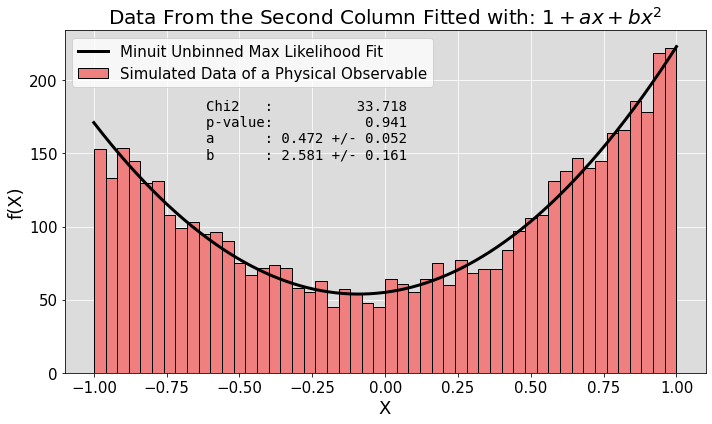

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Plot the data
ax.hist(data[:,1], N_bins, color='lightcoral', ec='k', zorder=2, 
        label='Simulated Data of a Physical Observable')

# Plot the fit
y_arr2 = norm_func_2(x_arr2, a_val_err2[0], b_val_err2[0]) * len(data[:,1]) * binwidth 
ax.plot(x_arr2, y_arr2, color='k', linewidth=3, zorder=3, label='Minuit Unbinned Max Likelihood Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2   :': chi2_col_2,
     r'p-value:': prob2,
     r'a      :': f'{a_val_err2[0]:.3f} +/- {a_val_err2[1]:.3f}',
     r'b      :': f'{b_val_err2[0]:.3f} +/- {b_val_err2[1]:.3f}',
    }

text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
AppStars.add_text_to_ax(0.22, 0.8, text, ax, fontsize=14, color='k')


# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data From the Second Column Fitted with: $1+ax+bx^2$', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('f(X)', fontsize=18)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_4.pdf')

plt.show()

## Third Column
We notice that all entires are integers. We therefor look to the discrete functions: f(k). We can disregard the logarithmic distibution, since the most likely value of k is larger than 1 (See distributions here https://en.wikipedia.org/wiki/Logarithmic_distribution). It can thus either be poisson or binomial.

In [19]:
# The function is not truncated, but both poisson and binomial are bounded at 0. 
# The largest value is 21, so we will bound it at 30
xlim3 = (0,30)
x_arr3 = np.linspace(xlim3[0],xlim3[1],xlim3[1]+1)

### Fitting with Minuit
We first define the target functions for both distributions

In [20]:
# ------ POISSON --------
def fit_poisson(k, lambd):
    
    # Initialise poisson with parameter lambda
    poisson = stats.poisson(lambd)
    
    # Return pmf
    return poisson.pmf(k)

def target_poisson(lambd):
    
    # Make pmf
    pmf = fit_poisson(data[:,2], lambd)
    
    # Calculate the log likelihood 
    llh = np.sum(np.log(pmf))
    
    # Return negative llh, when minimizing = max likelihood
    return -llh

# ------ BINOMIAL --------
def fit_binom(k, n, p):
    
    
    # Initialise poisson with parameter lambda
    binom = stats.binom(n, p)
    
    # Return pmf
    return binom.pmf(k)

def target_binom(n, p):
    
    # Make pmf
    pmf = fit_binom(data[:,2], n, p)
    
    # Calculate the log likelihood 
    llh = np.sum(np.log(pmf))
    
    # Return negative llh, when minimizing = max likelihood
    return -llh

In [21]:
# ------ FIT POISSON ------
target_p = target_poisson
target_p.errordef = Minuit.LIKELIHOOD

# Define parameters initial guess - the mean circa
params_p = {'lambd': 10}

# Initialize minimizer
minimizer_p = Minuit(target_p, **params_p)

# Enforce bounds to be within the range of the sample
minimizer_p.limits['lambd'] = xlim3

# Actually minimize
print('POISSON FIT')
minimizer_p.migrad()

POISSON FIT


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.291e+04                  │              Nfcn = 17               │
│ EDM = 3.58e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambd │   9.18    │   0.04    │            │            │    0    │   30    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────┐
│       │   lambd │
├───────┼─────────┤
│ lambd │ 0.00179 │
└───────┴─────────┘

In [22]:
# Extract values
lambd_val_err_p = (minimizer_p.values[0], minimizer_p.errors[0])

In [23]:
# ------ FIT BINOMIAL ------
target_b = target_binom
target_b.errordef = Minuit.LIKELIHOOD

# Define parameters initial guess - the mean (n*p) circa
params_b = {'n': 500, 'p':0.02}

# Initialize minimizer
minimizer_b = Minuit(target_b, **params_b)

# Enforce bounds on p due to it being a probability
minimizer_b.limits['p'] = (0,1)

# Actually minimize
print('BINOMIAL FIT')
minimizer_b.migrad(ncall=10000)

BINOMIAL FIT


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.291e+04                  │             Nfcn = 2372              │
│ EDM = 8.75e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │  11.0e3   │   0.8e3   │            │            │         │         │       │
│ 1 │ p    │  0.84e-3  │  0.06e-3  │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        n        p │
├───┼───────────────────┤
│ n │ 6.42e+05  -0.0487 │
│ p │  -0.0487 3.71e-09 │
└───┴───────────────────┘

In [24]:
# Extract values
n_val_err_b = (minimizer_b.values[0], minimizer_b.errors[0])
p_val_err_b = (minimizer_b.values[1], minimizer_b.errors[1])

### Chi2 Test

In [25]:
# Extract values from histogram and outline data
N_bins = xlim3[1]
counts, bin_edges = np.histogram(data[:,2], bins=np.arange(-0.5, xlim3[1],1))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
binwidth = bin_edges[1] - bin_edges[0]

# Poisson errors on the count in each bin
s_counts = np.sqrt(counts)
    
# We remove any bins, which don't have any counts in them:
x3 = bin_centers[counts>0]
y3 = counts[counts>0]
sy3 = s_counts[counts>0]

# ---- POISSON -----
# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = fit_poisson(x3, lambd_val_err_p[0])
y_exp_p = f_plot * len(data[:,2]) * binwidth
    
# Degrees of freedom
N_ddof = len(x3) - 1 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2_col_p = np.sum( (y3-y_exp_p)**2 / y_exp_p )
prob_p = stats.chi2.sf(chi2_col_p, df=N_ddof) 
print(f'POISSON: The Chi2 is: {chi2_col_p:.4f} with a p-value of: {prob_p:.4f}')

# ---- BINOMIAL -----
# Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
f_plot = fit_binom(x3, n_val_err_b[0], p_val_err_b[0])
y_exp_b = f_plot * len(data[:,2]) * binwidth
    
# Degrees of freedom
N_ddof = len(x3) - 2 #n_point - n_parameters, notice n_points is the no. of bin centers

# Calc chi2 and p value
chi2_col_b = np.sum( (y3-y_exp_b)**2 / y_exp_b )
prob_b = stats.chi2.sf(chi2_col_b, df=N_ddof) 
print(f'BINOMIAL: The Chi2 is: {chi2_col_b:.4f} with a p-value of: {prob_b:.4f}')

POISSON: The Chi2 is: 11.0599 with a p-value of: 0.9447
BINOMIAL: The Chi2 is: 11.1607 with a p-value of: 0.9183


### Plotting
The poisson distribution seems to be the best from the p-value. I believe this is due to one less degree of freedom. We will plot this one.

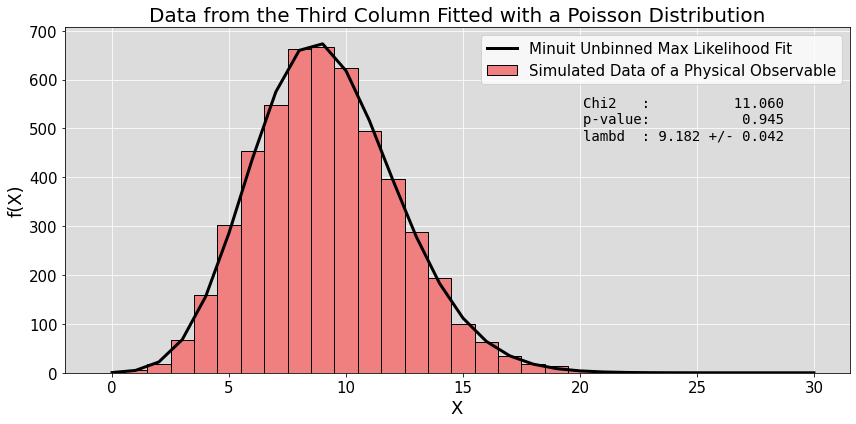

In [26]:
fig, ax = plt.subplots(figsize=(12, 6), sharey=True)

ax.set_facecolor('gainsboro')
ax.grid(color='white')

# ------ POISSON -------
# Plot the data
ax.hist(data[:,2], bins=np.arange(-0.5, xlim3[1],1), color='lightcoral', ec='k', zorder=2,
           label='Simulated Data of a Physical Observable')

# Plot the fit
y_arr_p = fit_poisson(x_arr3, lambd_val_err_p[0]) * len(data[:,2]) * binwidth
ax.plot(x_arr3, y_arr_p, color='k', linewidth=3, zorder=3, label='Minuit Unbinned Max Likelihood Fit')

# Put text of the fitted parameters on the plot
d = {r'Chi2   :': chi2_col_p,
     r'p-value:': prob_p,
     r'lambd  :': f'{lambd_val_err_p[0]:.3f} +/- {lambd_val_err_p[1]:.3f}',
    }

text = AppStars.nice_string_output(d, extra_spacing=1, decimals=3)
AppStars.add_text_to_ax(0.66, 0.8, text, ax, fontsize=14, color='k')

# Make pretty
ax.legend(prop={'size':15})
ax.set_title(r'Data from the Third Column Fitted with a Poisson Distribution', fontsize=20)
ax.set_xlabel('X', fontsize=18)
ax.set_ylabel('f(X)', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SaveFig:
    plt.tight_layout()
    plt.savefig('Plots/1_5.pdf')

plt.show()